In [7]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import csv
import cv2
import seaborn as sns
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
sns.set()
from PIL import Image
from matplotlib import image
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from keras.utils.np_utils import to_categorical   
from sklearn.model_selection import train_test_split

In [8]:
# images = [cv2.imread(file) for file in glob.glob("\GTSRB\Training\00000\*.ppm")]
train_data_path = ".\dataset\Train.csv"
test_data_path = ".\dataset\Test.csv"
train_path = "dataset\Train"

train_data = pd.read_csv(train_data_path)

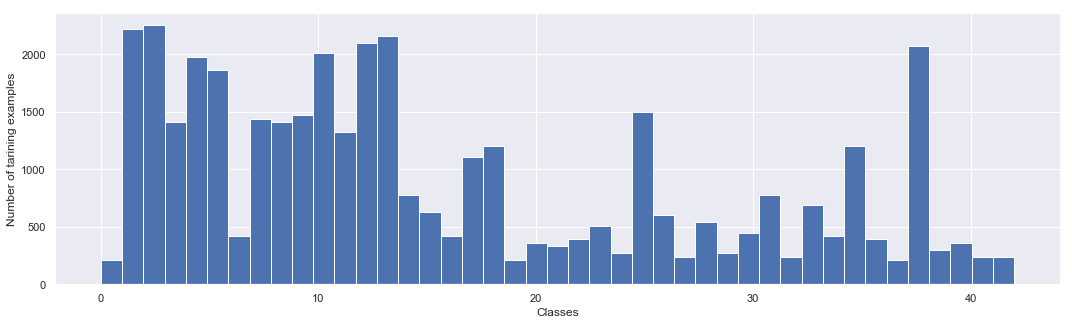

In [9]:
plt.figure(figsize=[18,5]);
plt.hist(train_data["ClassId"], bins=43, );
plt.ylabel("Number of tarining examples");
plt.xlabel("Classes");

In [10]:
train_data.describe()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
count,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000
mean,50.835880,50.328930,5.999515,5.962381,45.197302,44.728379,15.788390
std,24.306933,23.115423,1.475493,1.385440,23.060157,21.971145,12.013238
min,25.000000,25.000000,0.000000,5.000000,20.000000,20.000000,0.000000
25%,35.000000,35.000000,5.000000,5.000000,29.000000,30.000000,5.000000
50%,43.000000,43.000000,6.000000,6.000000,38.000000,38.000000,12.000000
75%,58.000000,58.000000,6.000000,6.000000,53.000000,52.000000,25.000000
max,243.000000,225.000000,20.000000,20.000000,223.000000,205.000000,42.000000


In [11]:
train_data.keys()

Index(['Width', 'Height', 'Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2', 'ClassId',
       'Path'],
      dtype='object')

In [12]:
train_data.head(5)

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


#### Pre-processing
##### 1. Load image
##### 2. Resize image to 32* 32
##### 3. Convert to grayscale
##### 4. Eqilize image for better contrast
##### 5. Convert image between range [0 and 1]
##### 6. Convert labels to one-hot

In [13]:
img_dimentions = (32,32)
def pre_processing_(train_data):
    number_of_images = train_data.shape
    number_of_images[0]

    train_images = []

    for i in range(number_of_images[0]):
        img = cv2.imread("dataset/"+train_data.Path[i])
        img = cv2.resize(img, img_dimentions) # resizing images to 32 x 32 pixels
        img_grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert RBG images to grayscale
        img_equilize = cv2.equalizeHist(img_grayscale) # improve contrast
        img_scale = img_grayscale / 255.00

        train_images.append(img_scale)
    # One- hot encoding labels
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(train_data.ClassId)
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    train_labels = onehot_encoder.fit_transform(integer_encoded)
    return np.array(train_images), train_labels

train_images, train_labels = pre_processing_(train_data)

D:\Installed_Softwares\Anaconda\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


### Augmentation
#### 1. Flip image horizontally

In [14]:
#     # Classes of signs that, when flipped horizontally, should still be classified as the same class
horizontally_flippable = np.array([11, 12, 13, 15, 17, 18, 22, 26, 30, 35])
# Classes of signs that, when flipped vertically, should still be classified as the same class
vertically_flippable = np.array([1, 5, 12, 15, 17])
# Classes of signs that, when flipped horizontally and then vertically, should still be classified as the same class
both_flippable = np.array([32, 40])
# Classes of signs that, when flipped horizontally, would still be meaningful, but should be classified as some other class
horizontally_cross_flippable = np.array([
    [19, 20], 
    [33, 34], 
    [36, 37], 
    [38, 39],
    [20, 19], 
    [34, 33], 
    [37, 36], 
    [39, 38],   
])

# flipped images 
flipped_images = []
flipped_labels = []

## TODO: Optimize for loop
for i in range(train_images.shape[0]):
    # for horizontally flippable images
    if np.where(train_labels[i] == 1)[0][0] in horizontally_flippable:
        flipped_images.append(cv2.flip(train_images[i], flipCode=1)) # horizontal flip
        flipped_labels.append(train_labels[i])
#     print(type(train_labels[i]))
    
    # for vertically flippable images
    if np.where(train_labels[i] == 1)[0][0] in vertically_flippable:
        flipped_images.append(cv2.flip(train_images[i], flipCode=0)) # vertical flip
        flipped_labels.append(train_labels[i])
    # for both flippable images
    if np.where(train_labels[i] == 1)[0][0] in both_flippable:
        flipped_images.append(cv2.flip(train_images[i], flipCode=-1)) # both flip
        flipped_labels.append(train_labels[i])
    
    if np.where(train_labels[i] == 1)[0][0] in horizontally_cross_flippable[:, 0]:
        flipped_images.append(cv2.flip(train_images[i], flipCode=1)) # horizontally cross flip
        data_label = int(horizontally_cross_flippable[np.where(horizontally_cross_flippable[:,0] == np.where(train_labels[i] == 1)[0][0]) ,1])
        flipped_labels.append(to_categorical(data_label, num_classes=43))
print(f"Number of flipped images: {len(flipped_images)} and labels: {len(flipped_labels)}")

Number of flipped images: 24329 and labels: 24329


In [15]:
# Adding flipped images to original dataset
print(f"Number of original images: {len(train_images)} and original labels: {len(train_labels)}")
train_images = np.append(train_images, flipped_images, axis = 0)
# flipped_labels = np.array(flipped_labels)
train_labels = np.append(train_labels, flipped_labels, axis =0)
print(f"Number of total images: {len(train_images)} and total labels: {len(train_labels)}")
# train_images = train_images.append(flipped_images)


Number of original images: 39209 and original labels: 39209
Number of total images: 63538 and total labels: 63538


In [16]:
train_images = np.reshape(train_images,(train_images.shape[0], train_images.shape[1], train_images.shape[2], 1))

In [17]:
x_train, x_test, y_train,  y_test = train_test_split(train_images, train_labels, test_size=0.30) 

In [25]:
# Conv layer 1
from tensorflow.keras import models, layers
conv_model = models.Sequential()
conv_model.add(layers.Conv2D(32, kernel_size=5, input_shape=(32,32,1), padding='same', activation='relu'))
conv_model.add(layers.MaxPool2D((2,2)))
#conv_model.add(Dropout(0.1))

# Conv layer 2
conv_model.add(layers.Conv2D(64, kernel_size=5, padding='same', activation='relu'))
conv_model.add(layers.MaxPool2D(2,2))
#conv_model.add(Dropout(0.2))

# Conv layer 3
conv_model.add(layers.Conv2D(128, kernel_size=5, padding='same', activation='relu'))
conv_model.add(layers.MaxPool2D(2,2))
#conv_model.add(Dropout(0.3))

# Flatten
conv_model.add(layers.Flatten())
#conv_model.add(Dropout(0.5))

# Fully connected layer 1:
conv_model.add(layers.Dense(1024, activation='relu'))

# Output layer
conv_model.add(layers.Dense(43, activation='softmax'))

# Save the entire model to a HDF5 file.
conv_model.save('./model/gtsc_model.hd5') 

conv_model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 32, 32)        832       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        51264     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
__________

In [19]:
checkpoint_path = ".\model\model_checkpouint.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_weights_only = True, verbose = 1)

conv_model.compile(optimizer= "adam", loss='categorical_crossentropy', metrics=['accuracy'])

# Training model and saving checkpoint for each epochs
conv_model.fit(x_train, y_train, epochs=4, callbacks = [cp_callback])


Instructions for updating:
Use tf.cast instead.
Epoch 1/4
44448/44476 [============================>.] - ETA: 0s - loss: 0.8057 - acc: 0.7747
Epoch 00001: saving model to .\model\model_checkpouint.ckpt

Consider using a TensorFlow optimizer from `tf.train`.
Instructions for updating:
Use tf.train.CheckpointManager to manage checkpoints rather than manually editing the Checkpoint proto.
44476/44476 [==============================] - 230s 5ms/sample - loss: 0.8053 - acc: 0.7748
Epoch 2/4
44448/44476 [============================>.] - ETA: 0s - loss: 0.0883 - acc: 0.9739
Epoch 00002: saving model to .\model\model_checkpouint.ckpt

Consider using a TensorFlow optimizer from `tf.train`.
44476/44476 [==============================] - 227s 5ms/sample - loss: 0.0883 - acc: 0.9739
Epoch 3/4
44448/44476 [============================>.] - ETA: 0s - loss: 0.0454 - acc: 0.9865
Epoch 00003: saving model to .\model\model_checkpouint.ckpt

Consider using a TensorFlow optimizer from `tf.train`.
44476/4

In [20]:
test_loss, test_accuracy = conv_model.evaluate(x_test, y_test)
print(f"\nAccuracy: {test_accuracy*100} and Loss : {test_loss} ")

19062/19062 [==============================] - 29s 2ms/sample - loss: 0.0795 - acc: 0.9772

Accuracy: 97.71797060966492 and Loss : 0.07954639483432134 


In [21]:
# TODO: Plot images and labels
# actual_pred = []
# n = 10
# prediction = conv_model.predict(x_test[:n])

# for i in range(n):
#     plt.grid(False)
#     plt.imshow(plt.imshow(np.reshape(x_test[i], (x_test[i].shape[0],x_test[i].shape[1]))))
#     plt.xlabel("Actual label" + y_test[i])
#     plt.title("Predicted label" + actual_pred.append(np.argmax(prediction[i])))
    
# for i in range(n):
#     print(actual_pred[i], np.argmax(y_test[i]))

In [22]:
ls {checkpoint_dir}

 Volume in drive D is New Volume
 Volume Serial Number is 8209-4EE9

 Directory of D:\Work\Analytics\ml\Project\Traffic_sign_classification_with_CNN\german traffic signs\model

2020-03-07  03:08 PM    <DIR>          .
2020-03-07  03:08 PM    <DIR>          ..
2020-03-07  03:08 PM               101 checkpoint
2020-03-07  03:08 PM         9,606,301 model_checkpouint.ckpt.data-00000-of-00001
2020-03-07  03:08 PM             1,347 model_checkpouint.ckpt.index
               3 File(s)      9,607,749 bytes
               2 Dir(s)  16,677,326,848 bytes free


In [24]:
# Save the entire model to a HDF5 file.
conv_model.save('./model/gtsc_model.hd5') 